In [3]:
!pip install opencv-python
!pip install opencv-python-headless
from google.colab import files


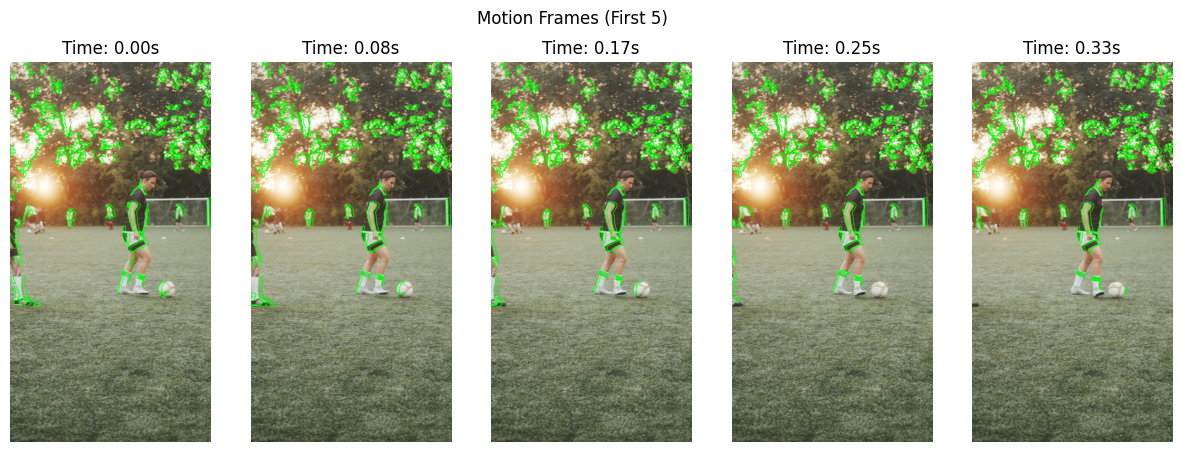

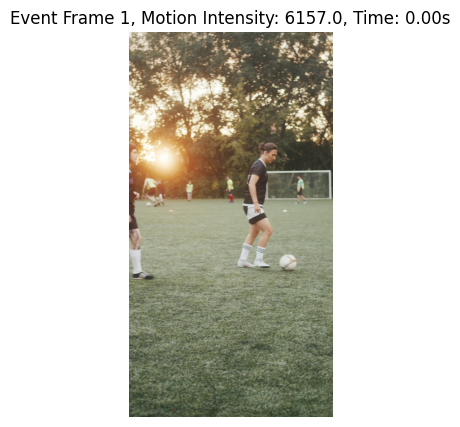

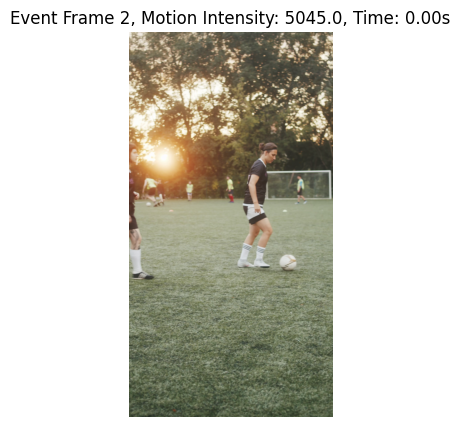

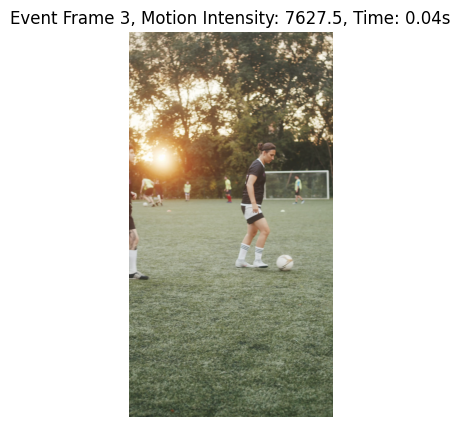

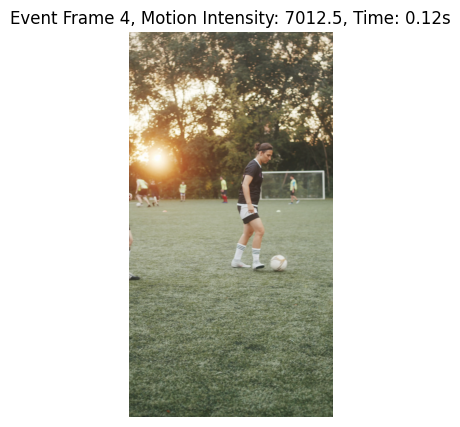

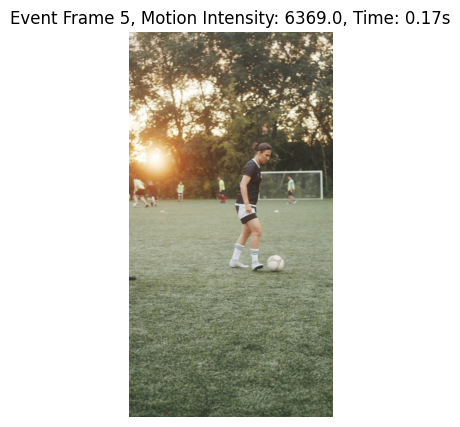

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the video
video_path = '/content/9517878-uhd_2160_4096_24fps.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    raise Exception("Could not open video")

# Get the frames per second (FPS) of the video
fps = cap.get(cv2.CAP_PROP_FPS)

# Read the first frame
ret, prev_frame = cap.read()
if not ret:
    raise Exception("Could not read frame from video")

# Downsample the video frames
scale_factor = 0.5  # Change this to 0.25 for more downsampling if needed
prev_frame = cv2.resize(prev_frame, None, fx=scale_factor, fy=scale_factor)
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Prepare for motion estimation
motion_frames = []
event_frames = []
event_threshold = 5000  # Arbitrary threshold for motion event detection
frame_count = 0

# Process the video frame by frame
while True:
    ret, frame = cap.read()
    if not ret:
        break  # Exit if there are no more frames

    # Downsample the current frame
    frame = cv2.resize(frame, None, fx=scale_factor, fy=scale_factor)

    # Convert the current frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate the absolute difference between the current frame and the previous frame
    frame_diff = cv2.absdiff(prev_gray, gray)

    # Threshold the difference to get a binary image
    _, thresh = cv2.threshold(frame_diff, 30, 255, cv2.THRESH_BINARY)

    # Find contours of the motion regions
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original frame for visualization
    motion_frame = frame.copy()
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter out small contours
            cv2.drawContours(motion_frame, [contour], -1, (0, 255, 0), 2)
            motion_intensity = cv2.contourArea(contour)
            if motion_intensity > event_threshold:
                timestamp = frame_count / fps  # Calculate timestamp in seconds
                event_frames.append((frame, motion_intensity, timestamp))

    # Store the motion visualizations
    motion_frames.append(motion_frame)

    # Prepare for the next iteration
    prev_gray = gray
    frame_count += 1

    # Skip frames to reduce memory usage (process every 2nd frame)
    if frame_count % 2 == 0:
        continue

# Release the video capture object
cap.release()

# Function to visualize motion frames and event frames with timestamps
def display_frames_with_timestamps(frames, title, timestamps=None):
    plt.figure(figsize=(15, 5))
    for i, frame in enumerate(frames):
        plt.subplot(1, len(frames), i + 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        if timestamps:
            plt.title(f"Time: {timestamps[i]:.2f}s")
    plt.suptitle(title)
    plt.show()

# Display motion frames with timestamps
timestamps_motion = [i / (fps / 2) for i in range(len(motion_frames))]  # Generate timestamps for motion frames
display_frames_with_timestamps(motion_frames[:5], "Motion Frames (First 5)", timestamps_motion)

# Display event frames with intensity information and timestamps
for i, (event_frame, intensity, timestamp) in enumerate(event_frames[:5]):
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(event_frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Event Frame {i + 1}, Motion Intensity: {intensity}, Time: {timestamp:.2f}s")
    plt.axis('off')
    plt.show()


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import feature

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to load images and their labels
def load_dataset(image_folder):
    images = []
    labels = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust for your image formats
            image_path = os.path.join(image_folder, filename)
            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)
                # Assuming label is part of filename e.g., "male_01.jpg"
                label = filename.split('_')[0]  # Extracting gender from filename
                labels.append(label)
    return images, labels

# Preprocess the image: face detection and normalization
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)
    if len(faces) == 0:
        return None  # No faces detected
    for (x, y, w, h) in faces:
        face = image[y:y + h, x:x + w]
        return cv2.resize(face, (128, 128))  # Resize to a fixed size

# Function for feature extraction using LBP
def extract_features(face_image):
    # Compute LBP
    lbp = feature.local_binary_pattern(face_image, P=8, R=1, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, 11),
                                 range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= lbp_hist.sum()  # Normalize the histogram

    # Geometric-based features: Example distances between facial landmarks (dummy)
    jawline_width = np.random.rand()  # Dummy value

    return {'lbp_hist': lbp_hist, 'jawline_width': jawline_width}

# Rule-based gender identification
def identify_gender(features):
    # Example rule: if jawline width > threshold, classify as male, else female
    if features['jawline_width'] > 0.5:  # This threshold should be defined based on analysis
        return 'Male'
    else:
        return 'Female'

# Main process
def main(image_folder):
    images, labels = load_dataset(image_folder)
    results = []

    for image, true_label in zip(images, labels):
        preprocessed_image = preprocess_image(image)
        if preprocessed_image is None:
            continue  # Skip if no face is detected
        features = extract_features(preprocessed_image)
        gender = identify_gender(features)
        results.append((true_label, gender, features['lbp_hist']))

    return results

# Define your dataset path
image_folder = '/path/to/your/facial/images'  # Replace with your actual dataset path

# Execute the main function
results = main(image_folder)

# Display results
for true_label, predicted_gender, lbp_hist in results:
    print(f"True Label: {true_label}, Predicted Gender: {predicted_gender}")
    print("LBP Histogram:", lbp_hist)
    print("-" * 50)


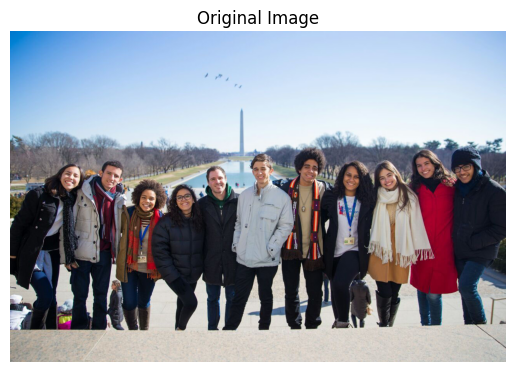

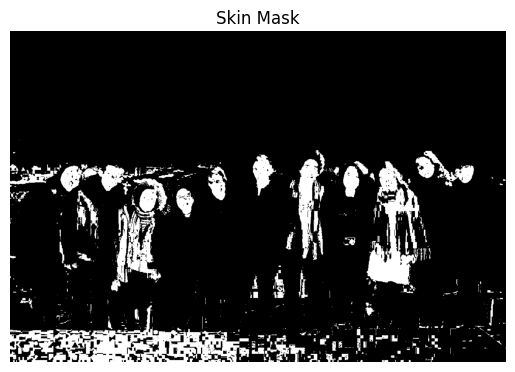

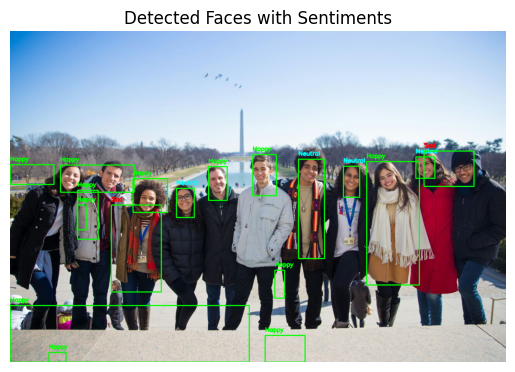

Overall Crowd Sentiment: Happy
Individual Sentiments: ['Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Happy', 'Happy', 'Neutral', 'Happy', 'Happy', 'Neutral', 'Happy', 'Happy', 'Happy', 'Neutral', 'Neutral', 'Happy', 'Sad']


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/What-We-Do_program-area_People-to-People-Exchanges_.jpg'  # Replace with your image file path
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    raise Exception("Could not open or find the image")

# Display the original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')
plt.show()

# Preprocessing: Convert to HSV color space for skin color detection
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define skin color range in HSV
lower_skin = np.array([0, 20, 70], dtype=np.uint8)
upper_skin = np.array([20, 255, 255], dtype=np.uint8)

# Create a mask for skin color
skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

# Display the skin mask
plt.imshow(skin_mask, cmap='gray')
plt.title("Skin Mask")
plt.axis('off')
plt.show()

# Find contours in the skin mask
contours, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image for visualization
detected_faces = image.copy()
face_sentiments = []

for contour in contours:
    area = cv2.contourArea(contour)
    if area > 500:  # Filter out small contours
        # Get the bounding box for the face
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(detected_faces, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Crop the detected face region
        face = image[y:y + h, x:x + w]

        # Simple facial feature analysis (average pixel value)
        # Convert to grayscale for analysis
        face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        mean_val = np.mean(face_gray)

        # Classify sentiment based on mean pixel value (dummy approach)
        # This is a simplified method; a real implementation would require more sophisticated analysis
        if mean_val > 100:
            sentiment = "Happy"
            cv2.putText(detected_faces, sentiment, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        elif mean_val < 80:
            sentiment = "Sad"
            cv2.putText(detected_faces, sentiment, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        else:
            sentiment = "Neutral"
            cv2.putText(detected_faces, sentiment, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        face_sentiments.append(sentiment)

# Display the detected faces with sentiment annotations
plt.imshow(cv2.cvtColor(detected_faces, cv2.COLOR_BGR2RGB))
plt.title("Detected Faces with Sentiments")
plt.axis('off')
plt.show()

# Overall sentiment categorization
if face_sentiments:
    majority_sentiment = max(set(face_sentiments), key=face_sentiments.count)
    overall_sentiment = f"Overall Crowd Sentiment: {majority_sentiment}"
else:
    overall_sentiment = "No faces detected."

print(overall_sentiment)
print("Individual Sentiments:", face_sentiments)


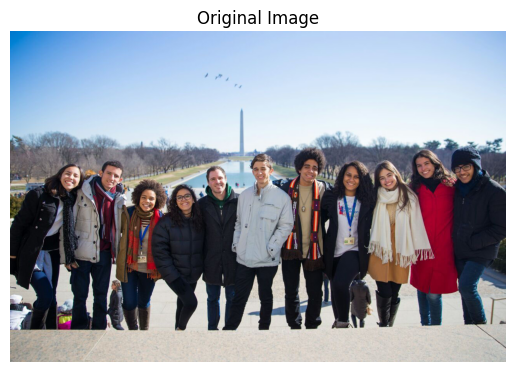

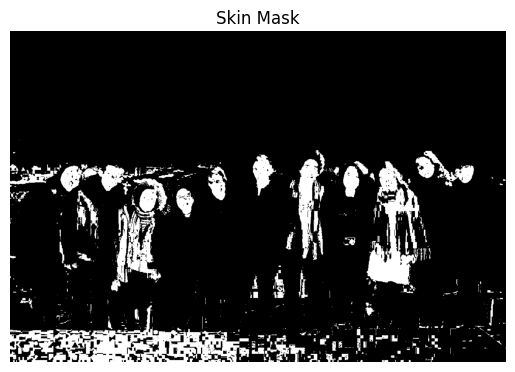

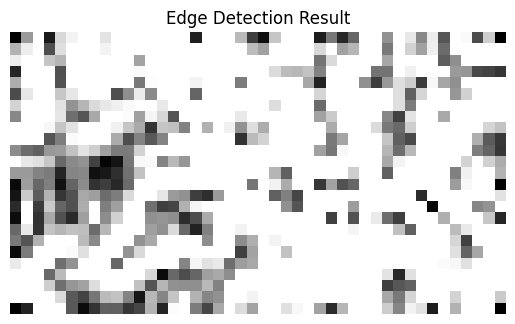

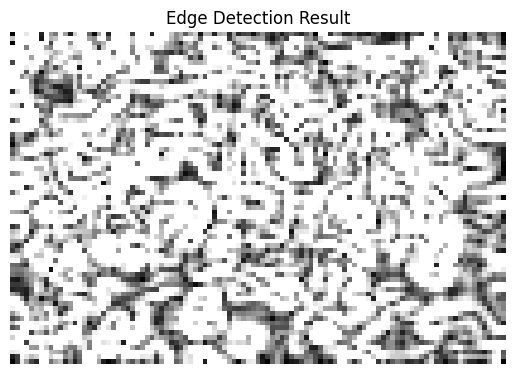

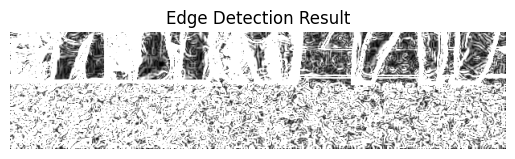

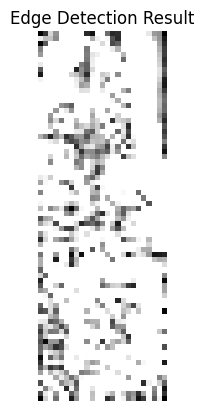

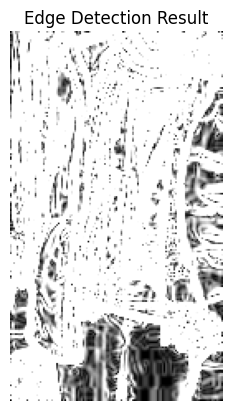

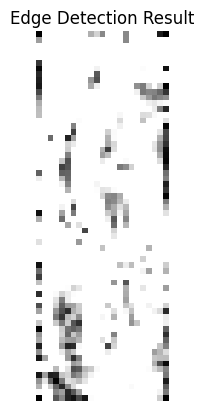

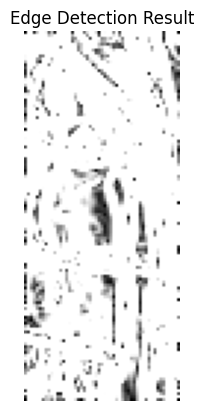

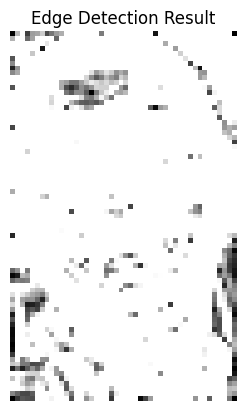

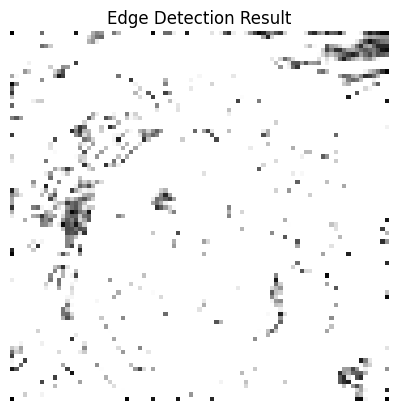

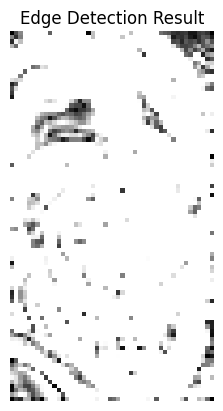

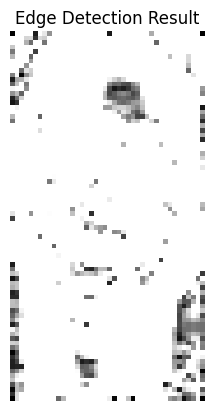

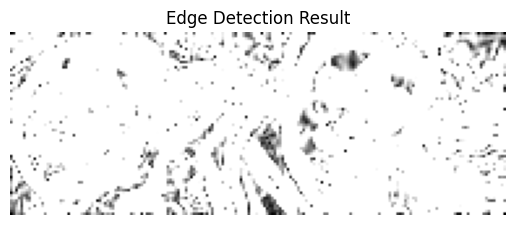

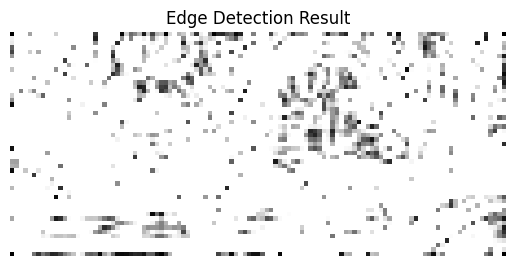

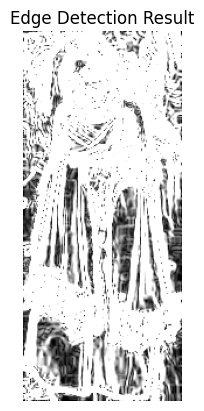

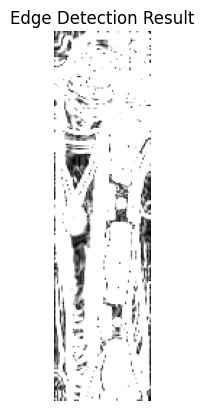

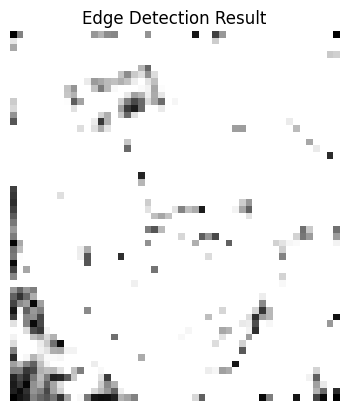

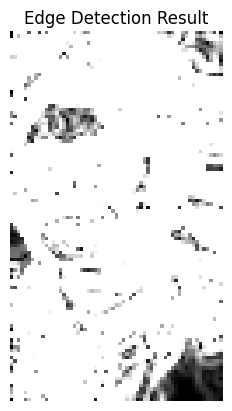

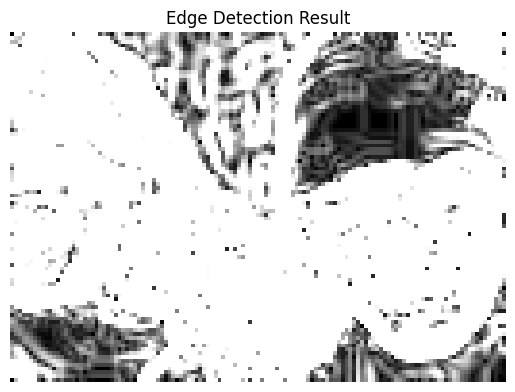

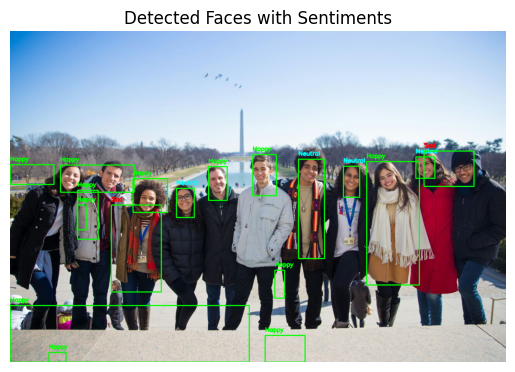

Overall Crowd Sentiment: Happy
Individual Sentiments: ['Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Happy', 'Happy', 'Neutral', 'Happy', 'Happy', 'Neutral', 'Happy', 'Happy', 'Happy', 'Neutral', 'Neutral', 'Happy', 'Sad']
Texture Features (LBP Histograms): [array([0.03363636, 0.06636364, 0.06636364, 0.16454545, 0.17545455,
       0.19545455, 0.09727273, 0.05909091, 0.04909091, 0.09272727]), array([0.0310961 , 0.07696637, 0.05276488, 0.13564092, 0.159561  ,
       0.18756156, 0.10989166, 0.06922752, 0.06922752, 0.10806247]), array([0.0356342 , 0.07281144, 0.0478453 , 0.12423126, 0.17783797,
       0.17530694, 0.09332608, 0.07513155, 0.09197176, 0.10590351]), array([0.05722222, 0.08833333, 0.06555556, 0.12      , 0.17333333,
       0.14388889, 0.08166667, 0.07277778, 0.07388889, 0.12333333]), array([0.0433624 , 0.08644795, 0.04180509, 0.09952935, 0.21366279,
       0.15251246, 0.06568383, 0.09143134, 0.09717608, 0.1083887 ]), array([0.03736413, 0.08831522, 0.05910326, 0.1080163 , 0.261548

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature

# Load the image
image_path = '/content/What-We-Do_program-area_People-to-People-Exchanges_.jpg'  # Replace with your image file path
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    raise Exception("Could not open or find the image")

# Display the original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')
plt.show()

# Preprocessing: Convert to HSV color space for skin color detection
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define skin color range in HSV
lower_skin = np.array([0, 20, 70], dtype=np.uint8)
upper_skin = np.array([20, 255, 255], dtype=np.uint8)

# Create a mask for skin color
skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

# Display the skin mask
plt.imshow(skin_mask, cmap='gray')
plt.title("Skin Mask")
plt.axis('off')
plt.show()

# Find contours in the skin mask
contours, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image for visualization
detected_faces = image.copy()
face_sentiments = []
face_textures = []  # To store LBP and edge detection results

for contour in contours:
    area = cv2.contourArea(contour)
    if area > 500:  # Filter out small contours
        # Get the bounding box for the face
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(detected_faces, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Crop the detected face region
        face = image[y:y + h, x:x + w]

        # Simple facial feature analysis (average pixel value)
        # Convert to grayscale for analysis
        face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        mean_val = np.mean(face_gray)

        # Classify sentiment based on mean pixel value (dummy approach)
        if mean_val > 100:
            sentiment = "Happy"
            cv2.putText(detected_faces, sentiment, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        elif mean_val < 80:
            sentiment = "Sad"
            cv2.putText(detected_faces, sentiment, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        else:
            sentiment = "Neutral"
            cv2.putText(detected_faces, sentiment, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        face_sentiments.append(sentiment)

        # Texture-based feature extraction using LBP
        lbp = feature.local_binary_pattern(face_gray, P=8, R=1, method='uniform')
        (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= lbp_hist.sum()  # Normalize the histogram
        face_textures.append(lbp_hist)

        # Edge detection using Sobel
        sobel_x = cv2.Sobel(face_gray, cv2.CV_64F, 1, 0, ksize=5)  # Sobel X
        sobel_y = cv2.Sobel(face_gray, cv2.CV_64F, 0, 1, ksize=5)  # Sobel Y
        sobel_edge = np.hypot(sobel_x, sobel_y)  # Combine both gradients
        sobel_edge = cv2.convertScaleAbs(sobel_edge)  # Convert back to uint8

        # Display edge detection result
        plt.imshow(sobel_edge, cmap='gray')
        plt.title("Edge Detection Result")
        plt.axis('off')
        plt.show()

# Display the detected faces with sentiment annotations
plt.imshow(cv2.cvtColor(detected_faces, cv2.COLOR_BGR2RGB))
plt.title("Detected Faces with Sentiments")
plt.axis('off')
plt.show()

# Overall sentiment categorization
if face_sentiments:
    majority_sentiment = max(set(face_sentiments), key=face_sentiments.count)
    overall_sentiment = f"Overall Crowd Sentiment: {majority_sentiment}"
else:
    overall_sentiment = "No faces detected."

print(overall_sentiment)
print("Individual Sentiments:", face_sentiments)
print("Texture Features (LBP Histograms):", face_textures)



Step 1: Training with labeled images...

Processing training image for male...
Features extracted for male training image

Processing training image for female...
Features extracted for female training image

Step 2: Processing test image...

Processing test image...


<ipython-input-11-73e25a302c80>:141: RuntimeWarning: overflow encountered in scalar subtract
  geo_diff = sum(abs(features1['geometric'][k] - features2['geometric'][k])



Step 3: Results
Total faces detected: 8

Face 1:
Predicted Gender: Male
Confidence: 1.00

Face 2:
Predicted Gender: Female
Confidence: 0.39

Face 3:
Predicted Gender: Female
Confidence: 0.00

Face 4:
Predicted Gender: Female
Confidence: 0.79

Face 5:
Predicted Gender: Male
Confidence: 0.33

Face 6:
Predicted Gender: Female
Confidence: 0.00

Face 7:
Predicted Gender: Male
Confidence: 0.33

Face 8:
Predicted Gender: Female
Confidence: 0.00


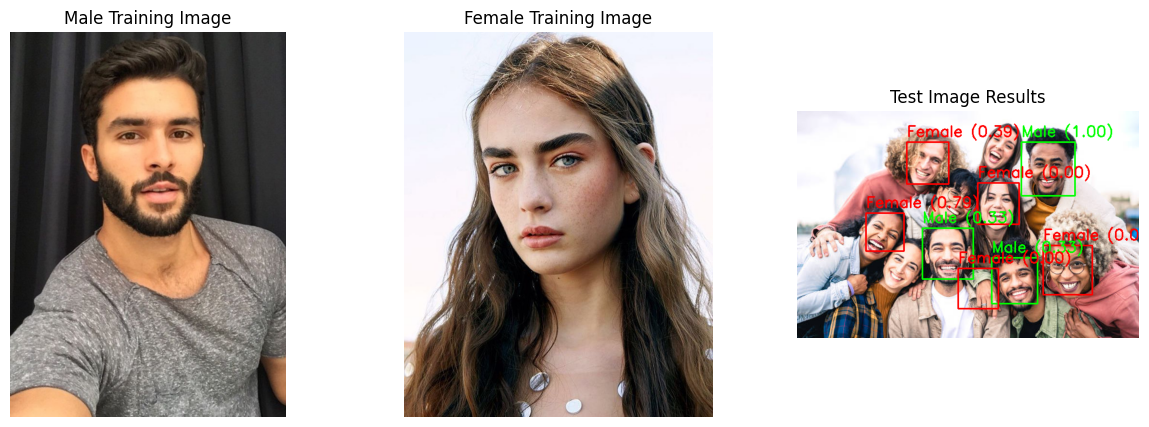

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

class GenderIdentifier:
    def __init__(self):
        # Initialize face detector
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # Initialize feature parameters
        self.target_size = (150, 150)  # Size for normalized faces
        self.lbp_points = 8
        self.lbp_radius = 1

        # Initialize gender features from training
        self.male_features = None
        self.female_features = None

    def load_and_process_training_image(self, image_path, gender):
        """Load and process training images for feature extraction"""
        print(f"\nProcessing training image for {gender}...")

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")

        # Detect face
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(
            gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        if len(faces) == 0:
            raise ValueError("No face detected in training image")

        # Process the first detected face
        x, y, w, h = faces[0]
        face_img = gray[y:y+h, x:x+w]

        # Normalize face size
        face_normalized = cv2.resize(face_img, self.target_size)

        # Extract features
        features = self._extract_features(face_normalized)

        # Store features based on gender
        if gender == 'male':
            self.male_features = features
        else:
            self.female_features = features

        print(f"Features extracted for {gender} training image")
        return features

    def _extract_features(self, face_img):
        """Extract geometric and texture features from face"""
        features = {}

        # 1. Geometric Features
        features['geometric'] = self._extract_geometric_features(face_img)

        # 2. Texture Features
        features['texture'] = self._extract_texture_features(face_img)

        return features

    def _extract_geometric_features(self, face_img):
        """Extract geometric features from face"""
        height, width = face_img.shape

        # Calculate horizontal projection (sum of pixel values along rows)
        horizontal_projection = np.sum(face_img, axis=1)

        # Calculate vertical projection (sum of pixel values along columns)
        vertical_projection = np.sum(face_img, axis=0)

        # Find key points using projections
        features = {
            'jaw_width': np.max(horizontal_projection[-int(height/3):]),
            'forehead_width': np.max(horizontal_projection[:int(height/3)]),
            'face_width_ratio': np.max(vertical_projection) / np.min(vertical_projection),
            'symmetry_score': self._calculate_symmetry(face_img)
        }

        return features

    def _extract_texture_features(self, face_img):
        """Extract texture features using LBP"""
        # Calculate LBP
        lbp = local_binary_pattern(
            face_img, self.lbp_points, self.lbp_radius, method='uniform')

        # Calculate histogram of LBP
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, self.lbp_points + 3),
                             range=(0, self.lbp_points + 2))

        # Normalize histogram
        hist = hist.astype('float') / (hist.sum() + 1e-7)

        # Calculate texture measures
        features = {
            'smoothness': np.std(hist),
            'uniformity': np.sum(hist ** 2),
            'entropy': -np.sum(hist * np.log2(hist + 1e-7))
        }

        return features

    def _calculate_symmetry(self, face_img):
        """Calculate facial symmetry score"""
        height, width = face_img.shape
        mid = width // 2
        left_side = face_img[:, :mid]
        right_side = cv2.flip(face_img[:, mid:], 1)

        # Calculate symmetry score (lower means more symmetric)
        return np.mean(np.abs(left_side - right_side))

    def analyze_gender(self, face_img):
        """Analyze gender based on extracted features"""
        features = self._extract_features(face_img)

        # Calculate feature differences from male and female templates
        male_score = self._calculate_feature_similarity(features, self.male_features)
        female_score = self._calculate_feature_similarity(features, self.female_features)

        # Make decision based on scores
        is_male = male_score < female_score
        confidence = abs(male_score - female_score) / (male_score + female_score)

        return "Male" if is_male else "Female", confidence

    def _calculate_feature_similarity(self, features1, features2):
        """Calculate similarity score between two feature sets"""
        if features1 is None or features2 is None:
            return float('inf')

        # Calculate geometric feature difference
        geo_diff = sum(abs(features1['geometric'][k] - features2['geometric'][k])
                      for k in features1['geometric'])

        # Calculate texture feature difference
        tex_diff = sum(abs(features1['texture'][k] - features2['texture'][k])
                      for k in features1['texture'])

        return geo_diff + tex_diff

    def process_image(self, image_path):
        """Process image and identify gender for all faces"""
        print("\nProcessing test image...")

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")

        # Create copy for drawing
        display_image = image.copy()

        # Detect faces
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(
            gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        results = []

        # Process each face
        for (x, y, w, h) in faces:
            # Extract and normalize face
            face_img = gray[y:y+h, x:x+w]
            face_normalized = cv2.resize(face_img, self.target_size)

            # Identify gender
            gender, confidence = self.analyze_gender(face_normalized)

            # Draw results
            color = (0, 255, 0) if gender == "Male" else (0, 0, 255)
            cv2.rectangle(display_image, (x, y), (x+w, y+h), color, 2)
            label = f"{gender} ({confidence:.2f})"
            cv2.putText(display_image, label, (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

            results.append({
                'gender': gender,
                'confidence': confidence,
                'position': (x, y, w, h)
            })

        return display_image, results

def main():
    # Initialize gender identifier
    identifier = GenderIdentifier()

    # Train with labeled images
    print("\nStep 1: Training with labeled images...")
    male_features = identifier.load_and_process_training_image("/content/male.jpg", "male")
    female_features = identifier.load_and_process_training_image("/content/female.jpg", "female")

    # Process test image
    print("\nStep 2: Processing test image...")
    test_image_path = "/content/group.jpg"
    result_image, results = identifier.process_image(test_image_path)

    # Display results
    print("\nStep 3: Results")
    print(f"Total faces detected: {len(results)}")
    for i, result in enumerate(results, 1):
        print(f"\nFace {i}:")
        print(f"Predicted Gender: {result['gender']}")
        print(f"Confidence: {result['confidence']:.2f}")

    # Display images
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(cv2.cvtColor(cv2.imread("/content/male.jpg"), cv2.COLOR_BGR2RGB))
    plt.title('Male Training Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(cv2.cvtColor(cv2.imread("/content/female.jpg"), cv2.COLOR_BGR2RGB))
    plt.title('Female Training Image')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title('Test Image Results')
    plt.axis('off')

    plt.show()

# Run the analysis
main()